# Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import matplotlib.colors as cls
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

In [10]:
class Road:
    
    def __init__(self, direction, road_length=100, car_density=0.2, 
                 prob_slow=0.5, max_speed=5):
        """
        Create and update a road for Traffic Simulation
        Attributes:
        -----------
        direction (str) The direction of the traffic on road. 'r' for right, 'l' for
            left, 'u' for up, 'd' for down

        road_length (int) The number of cells in the road. Default: 100.

        car_density (float) The fraction of cells that have a car on them.
            Default: 0.2.

        prob_slow (float) The probability that a car will randomly slow down
            by 1 during an update step. Default: 0.5.

        max_speed (int) The maximum speed in car cells per update step.
            Default: 5.
        """
        self.direction = direction
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        self.intersections = {}
        self.average_traffic_flow = []

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))
    
    def create_intersection(self, location, road, light_duration, light_status, 
                            turning_prob):
        """
        Create an intersection for both the roads at given locations
        
        Parameters:
        -------------
        location : list
            Locations of intersection for current road and intersecting road.
        road : Road
            A road object that intersects with the current road
        light_duration : list
            Duration of green and red light in seconds as [Green, Red].
        light_status : Boolean
            True if light is green, False if light is red
        turning_prob : list
            Probability of turning at intersection for current road and 
            intersecting road. 
        """
        #remove any car if present at the intersection location
        self.state[location[0]] = -2
        
        #create the traffic light object
        light = TrafficLight(self, road, location, turning_prob[0], light_duration, light_status)
        #check if intersection already exists
        if location[0] not in self.intersections.keys():
            self.intersections[location[0]] = light
            #create intersection for the other road with opposite light object
            loc = [location[1], location[0]]
            turning_prob_2 = [turning_prob[1], turning_prob[0]]
            road.create_intersection(loc, self, light_duration, not light_status, 
                                     turning_prob_2)

class TrafficLight:
    
    def __init__(self, road1, road2, location, turning_prob, duration, status = True):
        """
        Class to create, store, and update traffic light properties at intersections
        Attributes:
        ------------
        road1: Road
            First road to which the light belongs
        road2 : Road
            Second road which intersects with the first road
        turning_prob : float
            Probability of turning from road1 to road2
        duration : list
            Duration of green and red light in seconds as [Green, Red].
        status : Boolean
            True if light is green, False if light is red. Default = True
        """
        self.road1 = road1
        self.road2 = road2
        self.location = location
        self.turning_prob = turning_prob
        self.duration = duration
        self.status = status
        self.counter = 0

    def update_light(self):
        """
        Update the light status at every timestep
        """
        self.counter += 1
        if self.status:
            dur = self.duration[0]
        else:
            dur = self.duration[1]
        if self.counter == dur:
            self.status = not self.status #reverse the light
            self.counter = 0 #reset the counter


class TrafficSimulation:

    def __init__(self, roads):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:
        roads : list
            A list of Road objects.
        '''
        self.roads = roads
        # Keep track of the time steps
        self.time_step = 0
        self.avg_traffic_flow_raw = []

    def update(self):
        avg_history = []
        for road in self.roads:
            avg_history = self._update_single(road, avg_history)
        self.avg_traffic_flow_raw.append(sum(avg_history)/len(avg_history))
        self.time_step += 1

    def _update_single(self, road, avg_history):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(road.state >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            road.average_traffic_flow.append(0)
            self.time_step += 1
            return [0]

        # Get the speed of each cars
        car_speeds = road.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + road.road_length])))
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= road.max_speed,
            car_speeds + 1,
            road.max_speed)

        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < road.prob_slow)

        #deal with intersections
        for k in road.intersections.keys():
            light = road.intersections[k]
            for i in range(k-1, k-road.max_speed-1, -1):
                if i in car_indexes:
                    if not light.status:
                        #red: stop the cars behind the light    
                        car_speeds[np.where(car_indexes == i)[0]] = k-i-1
                    else:
                        #green: move the car forward or onto intersecting road
                        if np.random.uniform() > light.turning_prob:
                            #go straight with probability 1-turning_prob
                            continue
                        else:
                            road2 = light.road2
                            if road2.state[light.location[1] + 1] == -1: #if the next road is empty
                                #update that position to have a new car
                                road2.state[light.location[1] + 1] = light.location[1] + 1
                                #remove the car from the current road
                                deletion_index = np.where(car_indexes == i)[0]
                                car_indexes = np.delete(car_indexes, deletion_index)
                                car_speeds = np.delete(car_speeds, deletion_index)
                            else:
                                #stop the car at the light since the intersection is occupied
                                car_speeds[np.where(car_indexes == i)[0]] = k-i-1
                    break #break away once we find and update a car
            light.update_light()
        
        # Move cars forward using their new speeds
        car_indexes += car_speeds
        #remove cars that have crossed the road
        deletion_indices = np.where(car_indexes >= road.road_length)[0]
        car_speeds = np.delete(car_speeds, deletion_indices)
        car_indexes = np.delete(car_indexes, deletion_indices)
        road.state.fill(-1)
        road.state[car_indexes] = car_speeds
        #add new cars if car density is low
        if len(car_indexes) < int(road.car_density*road.road_length):
            req_num = int(road.car_density*road.road_length) - len(car_indexes)
            i = 0
            while road.state[i] == -1 and i < req_num:
                road.state[i] = np.random.randint(0, road.max_speed + 1)

        # Update traffic flow history
        road.average_traffic_flow.append(sum(car_speeds) / road.road_length)
        avg_history.extend(car_speeds)
        return avg_history
    
    def initialize(self):
        '''
        This will be called by the animator. It basically just creates figure
        for the figure function to use.
        '''
        # Create a new figure for use in the draw() method below
        self.figure, self.axes = plt.subplots()

    def draw(self):
        '''
        Draw the current state of the cellular automaton.
        '''
        state = np.full((40, 40), -3, dtype=int)
        state[10, :] = np.flip(self.roads[2].state)
        state[20, :] = self.roads[1].state
        state[30, :] = np.flip(self.roads[0].state)
        state[:, 10] = np.flip(self.roads[3].state)
        state[:, 20] = self.roads[4].state
        state[:, 30] = np.flip(self.roads[5].state)
        new_cmap = cls.ListedColormap(["LemonChiffon", "Red", "white", 
                                       [0, 0, 0, 0.2], [0, 0, 0, 0.3], [0, 0, 0, 0.4], 
                                       [0, 0, 0, 0.6], [0, 0, 0, 0.8], "black"])
        plot = self.axes.imshow(state, vmin=-3, vmax=5, cmap=new_cmap)
        self.axes.set_title(f'State at step {self.time_step}')
        return plot

In [3]:
#function to make animation - taken from session 6
def make_animation(sim, total_frames, steps_per_frame=1, interval=100):

    def update(frame_number):
        for _ in range(steps_per_frame):
	        sim.update()
        progress_bar.update(1)
        return [sim.draw()]

    sim.initialize()
    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, 
        interval=interval)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output

# Observed Strategy vs new Strategy

In [27]:
#test with observed parameters
road_len = 40
prob_slow = 0.3
car_density = 0.3
vtoh_turn_prob = 0.6
htov_turn_prob = 0.5
turn_probs = [htov_turn_prob, vtoh_turn_prob]
green_dur_base = 40
red_dur_base = 40
trials = 200

def initialize(car_density, prob_slow):
    #create roads
    Ellis = Road('l', road_len, car_density, prob_slow)
    Geary = Road('l', road_len, car_density, prob_slow)
    OFarrell = Road('r', road_len, car_density, prob_slow)
    Leavenworth = Road('u', road_len, car_density, prob_slow)
    Jones = Road('d', road_len, car_density, prob_slow)
    Taylor = Road('u', road_len, car_density, prob_slow)
    roads = [Ellis, OFarrell, Geary, Leavenworth, Jones, Taylor]

    #create intersections
    Ellis.create_intersection([10, 10], Taylor, [green_dur_base, red_dur_base], True, turn_probs)
    Ellis.create_intersection([20, 30], Jones, [green_dur_base+2, red_dur_base+2], True, turn_probs)
    Ellis.create_intersection([30, 10], Leavenworth, [green_dur_base-1, red_dur_base-1], True, turn_probs)
    OFarrell.create_intersection([10, 20], Leavenworth, [green_dur_base-1, red_dur_base-1], True, turn_probs)
    OFarrell.create_intersection([20, 20], Jones, [green_dur_base+2, red_dur_base+2], True, turn_probs)
    OFarrell.create_intersection([30, 20], Taylor, [green_dur_base, red_dur_base], True, turn_probs)
    Geary.create_intersection([30, 30], Leavenworth, [green_dur_base-1, red_dur_base-1], True, turn_probs)
    Geary.create_intersection([20, 10], Jones, [green_dur_base+2, red_dur_base+2], True, turn_probs)
    Geary.create_intersection([10, 30], Taylor, [green_dur_base, red_dur_base], True, turn_probs)
    return roads

#run the Traffic simulation
timesteps = 300
flows = []
for _ in range(trials):
    roads = initialize(car_density, prob_slow)
    test_simulation = TrafficSimulation(roads)
    for t in range(timesteps):
        test_simulation.update()
    #record last traffic flow for the complete system
    flows.append(test_simulation.avg_traffic_flow_raw[-1])
    if _%10 == 0:
        print(f"Completed {_} trials")
flows = np.array(flows)
test_mean = np.mean(flows)
test_std = sts.sem(flows)
#test_simulation.initialize()
#test_simulation.draw()
print(f"The average traffic flow is {test_mean:.{3}f} and the 95% confidence interval is [{(test_mean - 1.96*test_std):.{3}f}, {(test_mean + 1.96*test_std):.{3}f}]")

Completed 0 trials
Completed 10 trials
Completed 20 trials
Completed 30 trials
Completed 40 trials
Completed 50 trials
Completed 60 trials
Completed 70 trials
Completed 80 trials
Completed 90 trials
Completed 100 trials
Completed 110 trials
Completed 120 trials
Completed 130 trials
Completed 140 trials
Completed 150 trials
Completed 160 trials
Completed 170 trials
Completed 180 trials
Completed 190 trials
The average traffic flow is 0.417 and the 95% confidence interval is [0.404, 0.429]


In [29]:
#try animating the previous system
roads = initialize(car_density, prob_slow)
test_simulation = TrafficSimulation(roads)
make_animation(test_simulation, total_frames = 300)

  0%|          | 1/300 [00:01<05:17,  1.06s/it]/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)
100%|██████████| 300/300 [05:52<00:00,  1.18s/it]


<Figure size 432x288 with 0 Axes>

In [32]:
road_len = 40
prob_slow = 0.3
car_density = 0.3
vtoh_turn_prob = 0.6
htov_turn_prob = 0.5
turn_probs = [htov_turn_prob, vtoh_turn_prob]
green_dur_base = 40
red_dur_base = 40
trials = 200

def initialize2(car_density, prob_slow):
    #create roads
    Ellis = Road('l', road_len, car_density, prob_slow)
    Geary = Road('l', road_len, car_density, prob_slow)
    OFarrell = Road('r', road_len, car_density, prob_slow)
    Leavenworth = Road('u', road_len, car_density, prob_slow)
    Jones = Road('d', road_len, car_density, prob_slow)
    Taylor = Road('u', road_len, car_density, prob_slow)
    roads = [Ellis, OFarrell, Geary, Leavenworth, Jones, Taylor]

    #create intersections
    Ellis.create_intersection([10, 10], Taylor, [green_dur_base, red_dur_base], True, turn_probs)
    Ellis.create_intersection([20, 30], Jones, [green_dur_base, red_dur_base], False, turn_probs)
    Ellis.create_intersection([30, 10], Leavenworth, [green_dur_base, red_dur_base], True, turn_probs)
    OFarrell.create_intersection([10, 20], Leavenworth, [green_dur_base, red_dur_base], False, turn_probs)
    OFarrell.create_intersection([20, 20], Jones, [green_dur_base, red_dur_base], True, turn_probs)
    OFarrell.create_intersection([30, 20], Taylor, [green_dur_base, red_dur_base], False, turn_probs)
    Geary.create_intersection([30, 30], Leavenworth, [green_dur_base, red_dur_base], True, turn_probs)
    Geary.create_intersection([20, 10], Jones, [green_dur_base, red_dur_base], False, turn_probs)
    Geary.create_intersection([10, 30], Taylor, [green_dur_base, red_dur_base], True, turn_probs)
    return roads

#run the Traffic simulation
timesteps = 300
flows = []
for _ in range(trials):
    roads = initialize2(car_density, prob_slow)
    test_simulation = TrafficSimulation(roads)
    for t in range(timesteps):
        test_simulation.update()
    #record last traffic flow for the complete system
    flows.append(test_simulation.avg_traffic_flow_raw[-1])
    if _%10 == 0:
        print(f"Completed {_} trials")
flows = np.array(flows)
test_mean = np.mean(flows)
test_std = sts.sem(flows)
#test_simulation.initialize()
#test_simulation.draw()
print(f"The average traffic flow is {test_mean:.{3}f} and the 95% confidence interval is [{(test_mean - 1.96*test_std):.{3}f}, {(test_mean + 1.96*test_std):.{3}f}]")

Completed 0 trials
Completed 10 trials
Completed 20 trials
Completed 30 trials
Completed 40 trials
Completed 50 trials
Completed 60 trials
Completed 70 trials
Completed 80 trials
Completed 90 trials
Completed 100 trials
Completed 110 trials
Completed 120 trials
Completed 130 trials
Completed 140 trials
Completed 150 trials
Completed 160 trials
Completed 170 trials
Completed 180 trials
Completed 190 trials
The average traffic flow is 0.642 and the 95% confidence interval is [0.628, 0.656]


In [33]:
trials = 50
timesteps = 100
prob_slow = 0.3
densities = np.linspace(0, 1, 101)
average_flows_s1_3 = []  # The results go here
average_flows_s2_3 = []
for density in densities:
    flows = []
    flows_s2 = []
    for _ in range(trials):
        roads = initialize(density, prob_slow)
        roads_s2 = initialize2(density, prob_slow)
        test_simulation = TrafficSimulation(roads)
        test_simulation_s2 = TrafficSimulation(roads_s2)
        for t in range(timesteps):
            test_simulation.update()
            test_simulation_s2.update()
        #record last traffic flow for the complete system
        flows.append(test_simulation.avg_traffic_flow_raw[-1])
        flows_s2.append(test_simulation_s2.avg_traffic_flow_raw[-1])
    average_flows_s1_3.append(flows)
    average_flows_s2_3.append(flows_s2)
    if density%0.1 == 0:
        print(f"Finished simulation for density = {density}")
average_flows_s1_3 = np.array(average_flows_s1_3)
average_flows_s2_3 = np.array(average_flows_s2_3)

Finished simulation for density = 0.0
Finished simulation for density = 0.1
Finished simulation for density = 0.2
Finished simulation for density = 0.4
Finished simulation for density = 0.8


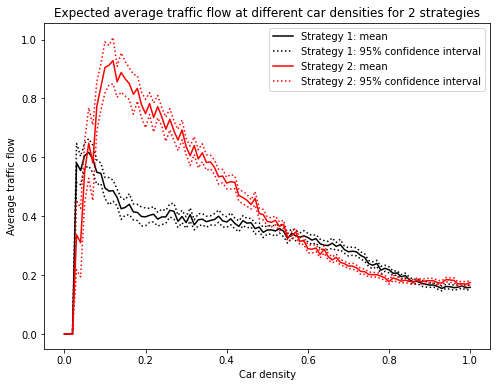

In [34]:
#plot the flow vs density
plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities for 2 strategies')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows_s1_3, axis=1)
std_err = sts.sem(average_flows_s1_3, axis=1)
plt.plot(densities, flow_mean, 'k-', label='Strategy 1: mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='Strategy 1: 95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')

flow_mean2 = np.mean(average_flows_s2_3, axis=1)
std_err2 = sts.sem(average_flows_s2_3, axis=1)
plt.plot(densities, flow_mean2, 'r-', label='Strategy 2: mean')
plt.plot(densities, flow_mean2 - 1.96 * std_err2, 'r:',
         label='Strategy 2: 95% confidence interval')
plt.plot(densities, flow_mean2 + 1.96 * std_err2, 'r:')
plt.legend()
plt.show()

In [35]:
prob_slow = 0.5
densities = np.linspace(0, 1, 101)
average_flows_s1_5 = []  # The results go here
average_flows_s2_5 = []
for density in densities:
    flows = []
    flows_s2 = []
    for _ in range(trials):
        roads = initialize(density, prob_slow)
        roads_s2 = initialize2(density, prob_slow)
        test_simulation = TrafficSimulation(roads)
        test_simulation_s2 = TrafficSimulation(roads_s2)
        for t in range(timesteps):
            test_simulation.update()
            test_simulation_s2.update()
        #record last traffic flow for the complete system
        flows.append(test_simulation.avg_traffic_flow_raw[-1])
        flows_s2.append(test_simulation_s2.avg_traffic_flow_raw[-1])
    average_flows_s1_5.append(flows)
    average_flows_s2_5.append(flows_s2)
    if density%0.1 == 0:
        print(f"Finished simulation for density = {density}")
average_flows_s1_5 = np.array(average_flows_s1_5)
average_flows_s2_5 = np.array(average_flows_s2_5)

Finished simulation for density = 0.0
Finished simulation for density = 0.1
Finished simulation for density = 0.2
Finished simulation for density = 0.4
Finished simulation for density = 0.8


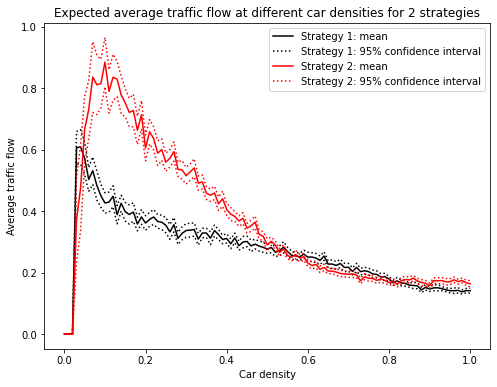

In [36]:
#plot the flow vs density
plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities for 2 strategies')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows_s1_5, axis=1)
std_err = sts.sem(average_flows_s1_5, axis=1)
plt.plot(densities, flow_mean, 'k-', label='Strategy 1: mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='Strategy 1: 95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')

flow_mean2 = np.mean(average_flows_s2_5, axis=1)
std_err2 = sts.sem(average_flows_s2_5, axis=1)
plt.plot(densities, flow_mean2, 'r-', label='Strategy 2: mean')
plt.plot(densities, flow_mean2 - 1.96 * std_err2, 'r:',
         label='Strategy 2: 95% confidence interval')
plt.plot(densities, flow_mean2 + 1.96 * std_err2, 'r:')
plt.legend()
plt.show()

In [37]:
prob_slow = 0.7
densities = np.linspace(0, 1, 101)
average_flows_s1_7 = []  # The results go here
average_flows_s2_7 = []
for density in densities:
    flows = []
    flows_s2 = []
    for _ in range(trials):
        roads = initialize(density, prob_slow)
        roads_s2 = initialize2(density, prob_slow)
        test_simulation = TrafficSimulation(roads)
        test_simulation_s2 = TrafficSimulation(roads_s2)
        for t in range(timesteps):
            test_simulation.update()
            test_simulation_s2.update()
        #record last traffic flow for the complete system
        flows.append(test_simulation.avg_traffic_flow_raw[-1])
        flows_s2.append(test_simulation_s2.avg_traffic_flow_raw[-1])
    average_flows_s1_7.append(flows)
    average_flows_s2_7.append(flows_s2)
    if density%0.1 == 0:
        print(f"Finished simulation for density = {density}")
average_flows_s1_7 = np.array(average_flows_s1_7)
average_flows_s2_7 = np.array(average_flows_s2_7)

Finished simulation for density = 0.0
Finished simulation for density = 0.1
Finished simulation for density = 0.2
Finished simulation for density = 0.4
Finished simulation for density = 0.8


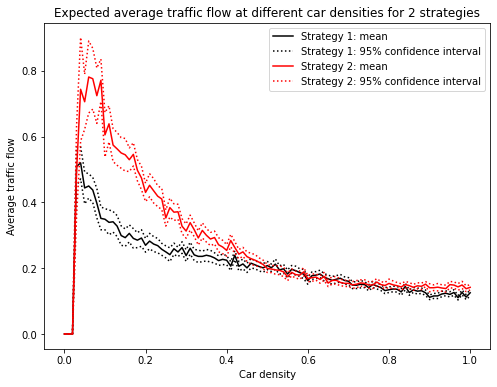

In [38]:
#plot the flow vs density
plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities for 2 strategies')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows_s1_7, axis=1)
std_err = sts.sem(average_flows_s1_7, axis=1)
plt.plot(densities, flow_mean, 'k-', label='Strategy 1: mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='Strategy 1: 95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')

flow_mean2 = np.mean(average_flows_s2_7, axis=1)
std_err2 = sts.sem(average_flows_s2_7, axis=1)
plt.plot(densities, flow_mean2, 'r-', label='Strategy 2: mean')
plt.plot(densities, flow_mean2 - 1.96 * std_err2, 'r:',
         label='Strategy 2: 95% confidence interval')
plt.plot(densities, flow_mean2 + 1.96 * std_err2, 'r:')
plt.legend()
plt.show()